In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')
from model import FinData
from model import train_valid_split
from model import CatboostFinModel

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

# from model.data import FinData
# from model.preprocessing import train_valid_split
# from ..model.model import CatboostFinModel

In [4]:
data = FinData("../../datasets/T_yandex_10min.csv")

data.insert_all()
# data.make_binary_class_target()

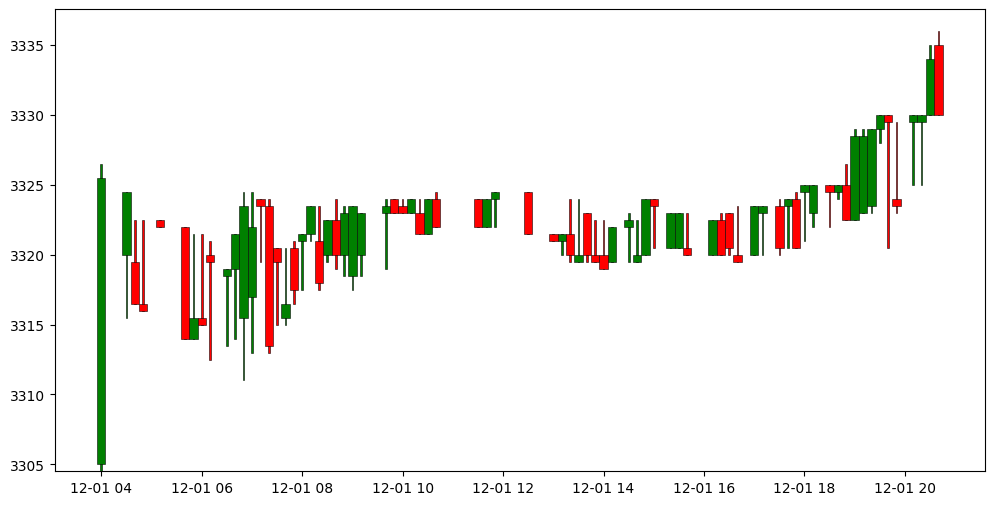

In [10]:
data.visualize_time_frame(dt.datetime(2024, 12, 1), dt.datetime(2024, 12, 2))

In [5]:
data.cat_features

['hours',
 'day',
 'minute',
 'is_holiday',
 'pred_holiday',
 'week_pred_holiday',
 'day_time',
 'season']

In [6]:
numeric = data.numeric_features[::5] + data.numeric_features[1::5]

cat = data.cat_features

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "reg_alpha" : 0.1, # L1
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

# data.restrict_time_down(2024, 11, 1)

In [7]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [13]:
y_train.shape

(134251,)

In [8]:
model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

TypeError: CatBoostClassifier.__init__() got an unexpected keyword argument 'reg_alpha'

Посмотрим на фильтр Баттерворта

In [28]:
data2 = FinData("../datasets/T_yandex_10min.csv")

data2.insert_shifts_norms([3, 6, 18])
data2.insert_rolling_means()
data2.insert_exp_rolling_means()
data2.insert_stochastic_oscillator()
data2.insert_high_low_diff()
data2.insert_butter_filter()
data2.insert_trend_rsi()
data2.insert_trend_rolling_means()
data2.insert_trend_deviation()

data2.make_binary_class_target()


In [8]:
numeric = data2.numeric_features

cat = data2.cat_features

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

X_train, X_val, y_train, y_val = train_valid_split(data=data2.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()


0:	learn: 0.6563452	test: 0.6262626	best: 0.6262626 (0)	total: 178ms	remaining: 29m 36s
100:	learn: 0.6615891	test: 0.6363636	best: 0.6464646 (7)	total: 3.59s	remaining: 5m 52s
200:	learn: 0.6668926	test: 0.6363636	best: 0.6464646 (7)	total: 7.35s	remaining: 5m 58s
300:	learn: 0.6711160	test: 0.6464646	best: 0.6464646 (7)	total: 11s	remaining: 5m 55s
400:	learn: 0.6740434	test: 0.6414141	best: 0.6464646 (7)	total: 14.6s	remaining: 5m 49s
500:	learn: 0.6759354	test: 0.6565657	best: 0.6565657 (480)	total: 17.9s	remaining: 5m 38s
600:	learn: 0.6774624	test: 0.6666667	best: 0.6666667 (595)	total: 21.5s	remaining: 5m 35s
700:	learn: 0.6785499	test: 0.6717172	best: 0.6717172 (649)	total: 25.1s	remaining: 5m 32s
800:	learn: 0.6795331	test: 0.6717172	best: 0.6717172 (649)	total: 28.4s	remaining: 5m 25s
900:	learn: 0.6801514	test: 0.6717172	best: 0.6717172 (649)	total: 31.9s	remaining: 5m 21s
1000:	learn: 0.6805983	test: 0.6666667	best: 0.6717172 (649)	total: 35.3s	remaining: 5m 17s
1100:	learn

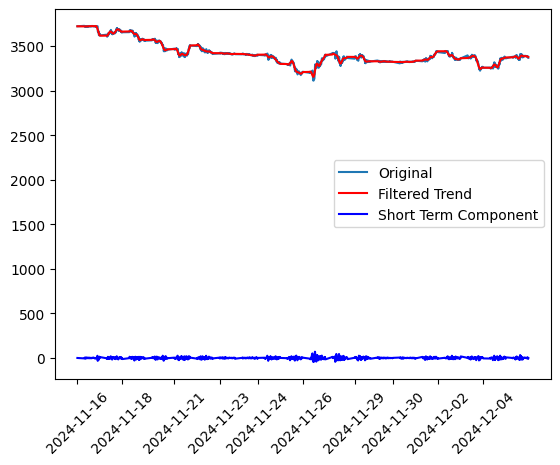

In [25]:
data2.restrict_time_down_stupidly(months=0, days=20)
data2.insert_butter_filter(visualise=True)